# Screening Exercise
*Ajinkya Sheth* <br>
ajinkya@uw.edu


The attached CSV file lists the customer, date, and dollar value of orders placed at a store in 2017. The actual gender and predicted gender of each customer is also provided.

Complete each of the following activities in a jupyter notebook or similar. Put your name and email at the top of the notebook and include your name in the notebook file name. Send back only your notebook file and please do not zip it.

For each question, state any considerations or assumptions you made.

In [1]:
import pandas as pd
import datetime
import time
from time import strftime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
orders_df=pd.read_csv('./screening_exercise_orders_v201810.csv')

## A) Assemble a dataframe with one row per customer and the following columns:
    * customer_id
    * gender
    * most_recent_order_date
    * order_count (number of orders placed by this customer)
   Sort the dataframe by customer_id ascending and display the first 10 rows.

In [3]:
customers_df=orders_df[['customer_id','gender','date']].groupby(['customer_id','gender']).agg(
    {'date':['max'],
     'customer_id':['count']})
customers_df.columns = ["_".join(x) for x in customers_df.columns.ravel()]
customers_df=customers_df.reset_index()
customers_df.columns = ['customer_id', 'gender','most_recent_order_date','order_count']
customers_df.sort_values(['customer_id'],ascending=True)[:10]

,customer_id,gender,most_recent_order_date,order_count
0,1000,0,2017-01-01 00:11:31,1
1,1001,0,2017-01-01 00:29:56,1
2,1002,1,2017-02-19 21:35:31,3
3,1003,1,2017-04-26 02:37:20,4
4,1004,0,2017-01-01 03:11:54,1
5,1005,1,2017-12-16 01:39:27,2
6,1006,1,2017-05-09 15:27:20,3
7,1007,0,2017-01-01 15:59:50,1
8,1008,0,2017-12-17 05:47:48,3
9,1009,1,2017-01-01 19:27:17,1


## B) Plot the count of orders per week for the store.

In [4]:
print('Max date: ' + str(orders_df['date'].max()))
print('Min date: ' + str(orders_df['date'].min()))

Max date: 2017-12-31 23:35:09
Min date: 2017-01-01 00:11:31


In [5]:
def get_week(text):
    t=time.strptime(text,"%Y-%m-%d %H:%M:%S")
    return strftime("%U",t)

In [6]:
weeks=pd.DataFrame(orders_df['date'].map(lambda l: get_week(l)))
count_by_week=weeks[['date']].groupby('date').agg({'date':['count']})
count_by_week.columns = ["_".join(x) for x in count_by_week.columns.ravel()]
count_by_week=count_by_week.reset_index()

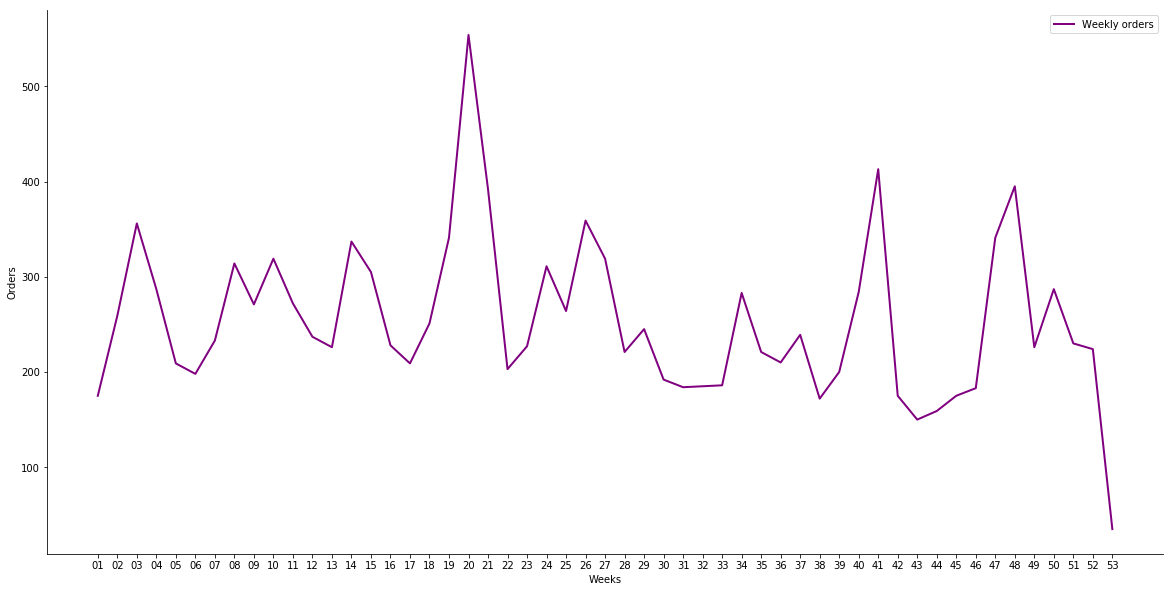

In [7]:
fig, ax=plt.subplots(1,1,figsize=(20,10))
ax.set_ylabel("Orders")
ax.set_xlabel("Weeks")
ax.plot(count_by_week['date'],count_by_week['date_count'],lw='2',c='purple',label='Weekly orders')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
leg = ax.legend();
plt.show()

## C) Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant?

We use t-statistic to find if the difference is significant or not

In [8]:
values_by_gender=orders_df[['gender','value']].groupby('gender').agg({'value':['mean','std','count']})
values_by_gender.columns = ["_".join(x) for x in values_by_gender.columns.ravel()]
values_by_gender=values_by_gender.reset_index()

In [9]:
values_by_gender

,gender,value_mean,value_std,value_count
0,0,363.890006,396.533215,6759
1,1,350.708361,377.504737,6712


In [10]:
gender0_mean=float(values_by_gender[values_by_gender['gender']==0]['value_mean'])
gender1_mean=float(values_by_gender[values_by_gender['gender']==1]['value_mean'])
gender0_std=float(values_by_gender[values_by_gender['gender']==0]['value_std'])
gender1_std=float(values_by_gender[values_by_gender['gender']==1]['value_std'])
gender0_count=float(values_by_gender[values_by_gender['gender']==0]['value_count'])
gender1_count=float(values_by_gender[values_by_gender['gender']==1]['value_count'])

In [11]:
calculated_t_statistic=(gender0_mean-gender1_mean)/np.sqrt(gender0_std**2/gender0_count + gender1_std**2/gender1_count)
print('calculated t-statistic: '+ str(calculated_t_statistic))

calculated t-statistic: 1.9761079335767466


**Assuming a t-critical to be 1.96 (for p-value of 0.05), if calculated t-statistic > t-critical we conclude that the difference is statistically significant.**

## D) Assuming a single gender prediction was made for each customer, generate a confusion matrix for predicted gender. What does the confusion matrix tell you about the quality of the predictions?

In [12]:
'''Following function have been borrowed from https://scikit-learn.org'''
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax,cm

Assuming 0 to be female and 1 to be male:

Confusion matrix, without normalization
[[3349 3410]
 [1463 5249]]


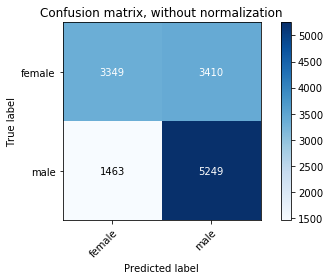

In [13]:
ax,cm = plot_confusion_matrix(orders_df['gender'],orders_df['predicted_gender'],['female','male'])

In [14]:
TP=cm[0][0] 
TN=cm[1][1]
FP=cm[1][0]
FN=cm[0][1]

In [15]:
accuracy=(TP+TN)/np.sum(cm)
TN_Rate=TN/(TN+FP)
TP_Rate=TP/(TP+FN)

In [16]:
accuracy

0.6382599658525722

In [17]:
TN_Rate

0.7820321811680572

In [18]:
TP_Rate

0.495487498150614

Here, TN_Rate corresponds to getting percentage of male predictions correct and TP_Rate corresponds to getting percentage of female predictions correct. Clearly, TN_Rate is much higher than TP_Rate. From confusion matrix we can conclude that the predictive model used is geared more towards getting one of the gender correct. 


## E) Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a problem. Limit your answer to one paragraph.

Scikit-learn is one of favorite tool to implement core machine learning models. Its intuitive and supplemented with great documentation. As a part of my data science class, I worked on a spam classifier project. I implemented two models SVM and Naive Bayes and compared their performance. Right from model fitting, model tuning to evaluation, Scikit-learn provides all this functionality to ease machine learning process. I used scikit-learn to split data between train and test data set. After which I started implemented SVM and tuned C parameter and gamma parameter of SVM model. After settling for the best possible accuracy score for SVM I implemented a Naive Bayes classifier. The accuracy score between two models was coming out to be very close. Hence, for an in-depth evalutation I used confusion matrix and selected the model based on F1 score I selected NB to be a better model.